# Simple sentiment analysis

Sentiment analysis, using iMDB database

First, implement and train a feedforward NN model with TF-IDF. And then train your
model using word2vec embedding. Report both training and development accuracy on
the dataset. Try to use stochastic gradient descent or (mini-batch) stochastic gradient
descent!

In [1]:
!pip install tensorflow
!pip install nltk
!pip install gensim
!pip install matplotlib

### imports


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import csv
import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

[nltk_data] Downloading package stopwords to /Users/uni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### load dataset into memory
return a list of docs and a list of respective labels

In [3]:
def load_data (filename):
  content = list()
  labels = list()

  has_header = True
  # detect if file has a header
  # with open(filename, 'r') as file:
  #   sample = file.read(64)
  #   has_header = csv.Sniffer().has_header(sample)

  with open(filename, 'r') as file:
    reader = csv.reader(file)
    # skip first line if file has a header 
    if has_header:
      next(reader)
    for c, l in reader:
      content.append(c)
      labels.append(l)
  return content, labels

### turn a dataset into clean tokens

In [4]:
def clean_data(data):
  corpus = list()
  corp_voc = dict()
  stop = nltk.corpus.stopwords.words("english")
  # regex tokenizer, find words, numbers and words containing '
  tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+(?:'\w)?")
  for doc in data:
    doc = tokenizer.tokenize(doc)
    doc_cleaned = dict()
    for tok in doc:
      # make all words lower case
      tok = tok.lower()
      # filter out numbers 
      if not tok.isdigit() and tok not in stop:
        # add clean token to document
        if tok in doc_cleaned:
          doc_cleaned[tok] += 1
        else:
          doc_cleaned[tok] = 1
    for tok in doc_cleaned.keys():
    # increase corpus vocabulary
        if tok in corp_voc:
          corp_voc[tok] += 1
        else:
          corp_voc[tok] = 1
    corpus.append(doc_cleaned)
  return corpus, corp_voc

# filter all words out of a corpus that are not in a vocabulary
def get_filtered_corpus(corpus, vocab):
  clean_corpus = list()
  for doc in corpus:
    clean_doc = dict()
    for tok in doc:
      if tok in vocab:
        clean_doc[tok] = doc[tok]
    clean_corpus.append(clean_doc)
  return clean_corpus

### preprocess the dataset

tf-idf vectorizer

In [5]:
# corpus must be a list of dicts of form (token: occurences)
# vocab must be a dict of form (token: documents in corpus containing token)
def preprocess_tf_idf(corpus, vocab):
  processed = np.zeros((len(corpus), len(vocab)))
  idf = get_idf(vocab)
  token_order = {tok: i for i, tok, in enumerate(sorted(vocab.keys()))}
  for n_doc, doc in enumerate(corpus):
    tf = get_tf(doc)
    for tok in set(doc):
      tok_pos = token_order[tok]
      processed[n_doc][tok_pos] = tf[tok]*idf[tok]
  return processed

def get_tf(doc):
  tf = dict()
  for tok, occ in doc.items():
    tf[tok] = occ / len(doc)
  return tf

def get_idf(corp_voc):
  idf = dict()
  for tok, docs_containing in corp_voc.items():
    idf[tok] = np.log10(len(corp_voc) / docs_containing)
  return idf


semantic embeddings
pooling word2vec embeddings

In [6]:
def preprocess_sem_vec(corpus):
  processed = list()
  model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
  total_used = 0
  total_available = 0
  for n_doc, doc in enumerate(corpus):
    vecs = [occ*model[tok] for tok, occ in doc.items() if tok in model.key_to_index]
    total_used += len(vecs)
    total_available += len(doc.items())
    processed.append(np.mean(vecs, axis=0))

  return np.array(processed)

load training data

In [7]:
# read data from file
raw_data, labels = load_data("Train.csv")
full_corpus, full_vocab = clean_data(raw_data)

# select part of vocabulary
frequencies = sorted(full_vocab.items(), key=lambda x : x[1], reverse=True)
# number of most common non-stop words that we consider
VOCAB_SIZE = 5000
# number of most frequent words to be disregarded, but this is now irrelevant due to the removal of stop words
HIGHER_CUTOFF = 0
vocab = {x[0] : x[1] for x in frequencies[HIGHER_CUTOFF:HIGHER_CUTOFF+VOCAB_SIZE]}

corpus = get_filtered_corpus(full_corpus, vocab.keys())
# process labels
taining_labels = np.array([0 if int(label) == 0 else 1 for label in labels])

load validation data

In [8]:
v_raw, v_labels = load_data("Valid.csv")
full_valid_corpus, _ = clean_data(v_raw)
valid_corpus = get_filtered_corpus(full_valid_corpus, vocab)
valid_labels = np.array([0 if int(label) == 0 else 1 for label in v_labels])

load testing data

In [9]:
t_raw, t_labels = load_data("Test.csv")
full_test_corpus, _ = clean_data(t_raw)
test_corpus = get_filtered_corpus(full_test_corpus, vocab)
test_labels = np.array([0 if int(label) == 0 else 1 for label in t_labels])

define and preprocess training, testing and validation data

In [10]:
# get tf-idf representation of data
tfidf_data = preprocess_tf_idf(corpus, vocab)
test_data = preprocess_tf_idf(test_corpus, vocab)
valid_data = preprocess_tf_idf(valid_corpus, vocab)

In [11]:
# get semantic embeddings of data
w2v_train_data = preprocess_sem_vec(corpus)
w2v_valid_data = preprocess_sem_vec(valid_corpus)
w2v_test_data = preprocess_sem_vec(test_corpus)

### define function for plotting the training history

In [12]:
def plot_training(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)

  # Plot the training and validation loss
  plt.plot(epochs, train_loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot the training and validation accuracy
  plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

### classify a review as negative or positive.

In [13]:
def predict_sentiment(model, doc):
  return model.predict(doc)

### define the model


In [14]:
def define_tf_idf_model(dropout=0.2, l1=1e-5, l2=1e-4):
  model = keras.models.Sequential()
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
  return model

## Running the model

In [15]:
TF_LEARNING_RATE = 4e-4
TF_BATCH_SIZE = 512
TF_EPOCHS = 100

TF_DROPOUT = 0.25
TF_L1 = 5e-6
TF_L2 = 5e-5

begin training
Epoch 1/100


2023-05-15 16:13:55.006522: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


79/79 [==============================] - 1s 10ms/step - loss: 0.7083 - accuracy: 0.6179 - val_loss: 0.6946 - val_accuracy: 0.7530
Epoch 2/100
79/79 [==============================] - 1s 10ms/step - loss: 0.6906 - accuracy: 0.7106 - val_loss: 0.6876 - val_accuracy: 0.7818
Epoch 3/100
79/79 [==============================] - 1s 9ms/step - loss: 0.6854 - accuracy: 0.7465 - val_loss: 0.6825 - val_accuracy: 0.7694
Epoch 4/100
79/79 [==============================] - 1s 11ms/step - loss: 0.6798 - accuracy: 0.7470 - val_loss: 0.6763 - val_accuracy: 0.7992
Epoch 5/100
79/79 [==============================] - 1s 9ms/step - loss: 0.6732 - accuracy: 0.7685 - val_loss: 0.6689 - val_accuracy: 0.7908
Epoch 6/100
79/79 [==============================] - 1s 9ms/step - loss: 0.6651 - accuracy: 0.7761 - val_loss: 0.6606 - val_accuracy: 0.8152
Epoch 7/100
79/79 [==============================] - 1s 9ms/step - loss: 0.6569 - accuracy: 0.7846 - val_loss: 0.6515 - val_accuracy: 0.8130
Epoch 8/100
79/79 [===

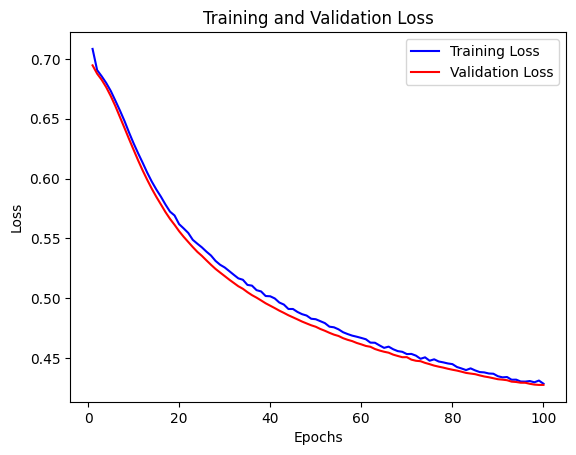

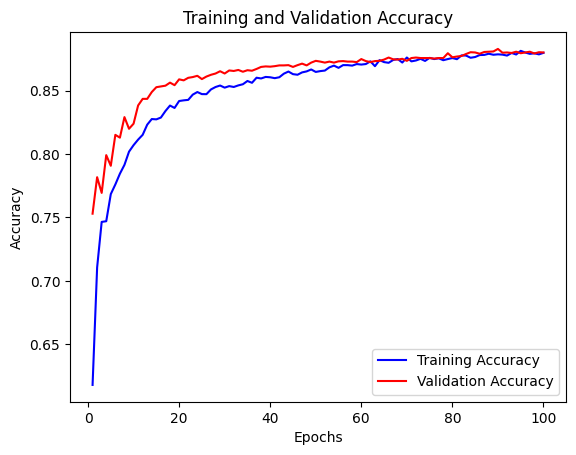

In [16]:
# build model
tfidf_model = define_tf_idf_model(dropout=TF_DROPOUT, l1=TF_L1, l2=TF_L2)
tfidf_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=TF_LEARNING_RATE),
    metrics=['accuracy'])
# train model
print("begin training")
history = tfidf_model.fit(
    tfidf_data,
    taining_labels,
    validation_data=(valid_data, valid_labels),
    epochs=TF_EPOCHS,
    batch_size=TF_BATCH_SIZE)
plot_training(history)

In [17]:
print("begin evaluation")
tfidf_model.evaluate(test_data, test_labels)

begin evaluation
157/157 [==============================] - 0s 703us/step - loss: 0.4259 - accuracy: 0.8902


[0.425873339176178, 0.8902000188827515]

train a model on word2vec embeddings

In [18]:
def define_word2vec_model(dropout=0.4, l1=1e-5, l2=1e-4):
  model = keras.models.Sequential()
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)))
  return model

In [19]:
W2V_LEARNING_RATE = 2e-4
W2V_BATCH_SIZE = 512
W2V_EPOCHS = 100

W2V_DROPOUT = 0.1
W2V_L1 = 2e-5
W2V_L2 = 1e-4

begin training
Epoch 1/100
79/79 [==============================] - 1s 5ms/step - loss: 0.8044 - accuracy: 0.7101 - val_loss: 0.7093 - val_accuracy: 0.7930
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.7894 - val_loss: 0.5574 - val_accuracy: 0.8154
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 0.5523 - accuracy: 0.8061 - val_loss: 0.5064 - val_accuracy: 0.8302
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 0.5217 - accuracy: 0.8179 - val_loss: 0.4817 - val_accuracy: 0.8420
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 0.5036 - accuracy: 0.8221 - val_loss: 0.4672 - val_accuracy: 0.8430
Epoch 6/100
79/79 [==============================] - 0s 5ms/step - loss: 0.4922 - accuracy: 0.8259 - val_loss: 0.4577 - val_accuracy: 0.8448
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 0.4846 - accuracy: 0.8272 - val_loss: 0.4492 - val_accuracy: 0.848

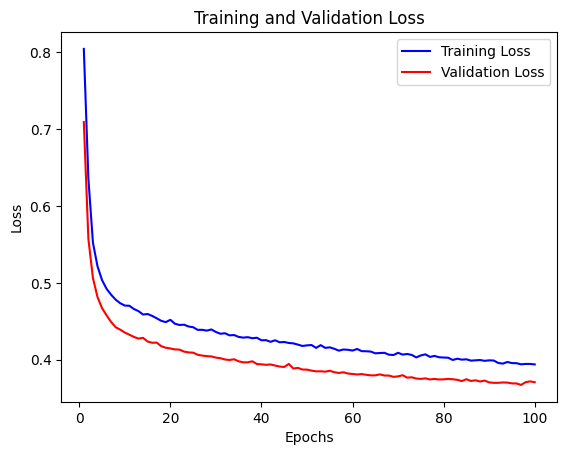

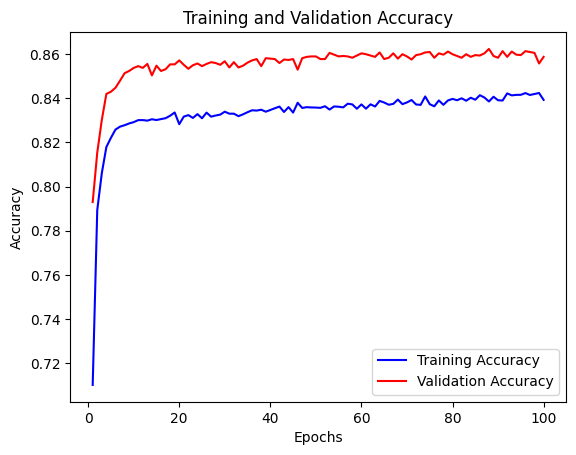

In [20]:
# build model
w2v_model = define_word2vec_model(dropout=W2V_DROPOUT, l1=W2V_L1, l2=W2V_L2)
w2v_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=W2V_LEARNING_RATE),
    metrics=['accuracy'])
# train model
print("begin training")
history = w2v_model.fit(
    w2v_train_data,
    taining_labels,
    validation_data=(w2v_valid_data, valid_labels),
    epochs=W2V_EPOCHS,
    batch_size=W2V_BATCH_SIZE)
plot_training(history)

In [21]:
print("begin evaluation")
w2v_model.evaluate(w2v_test_data, test_labels)

begin evaluation
157/157 [==============================] - 0s 734us/step - loss: 0.3830 - accuracy: 0.8500


[0.3830404281616211, 0.8500000238418579]